In [1]:
##### Limited influence of running speed on neuronal activity in mice visual cortex subregions: a comparative study using linear regression and binned analyses #####
### Active Movement on Neural Activity - Kaden Coulter ~ Bio 4/510 ~ Final Project ###

### !! Please ensure this .ipynb file lives in the same dir as E-Phys Data !! ####
### https://alleninstitute.org/open-science-tools/ ###

### Note: Figures have been adapted to better fit my personal preferences. Original PDF report figures may not appear as they do here. 

## Neurons Of Interest 
# VISp: Primary Visual Area 80-99, 219-258
# VISrl: Rostrolateral Visual Area 431-439, 553-573, 587-605, 612-638
# VISam: Anteromedial Visual Area 840-856, 871-883

## Potentially of Interest (Later Interest)
# VISl: Lateral Visual Area 
# VISpm: Posteralmedial Visual Area 

In [2]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import linregress
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# If statsmodels, scipy, or seaborn are not downloaded: ###
    # pip install numpy matplotlib pandas seaborn scipy statsmodels
    # conda install numpy matplotlib pandas seaborn scipy statsmodels

In [3]:
### DATA ###
# Load Data
gabors_stim = np.load('gabors_stim.npz')
gabors_spikes = np.load('gabors_spikes.npz')
gabors_areas = np.load('gabors_areas.npz')
gabors_running = np.load('gabors_running.npz')
g_unit_ids = gabors_spikes.files

# Comment in to see index of all Neurons
"""
for idx, g_unit_id in enumerate(g_unit_ids):
    brain_area = gabors_areas[g_unit_id]
    print(f"Unit ID {idx}: {brain_area}")
"""

'\nfor idx, g_unit_id in enumerate(g_unit_ids):\n    brain_area = gabors_areas[g_unit_id]\n    print(f"Unit ID {idx}: {brain_area}")\n'

In [4]:
### FUNCTION ###
def grabber(a, b): # To Collect Data
    data_range = list(range(a, b+1)) # Grab from a to b (inclusive)
    arr = np.concatenate([gabors_spikes[g_unit_ids[ind]] for ind in data_range])
    return np.sort(arr)

In [5]:
### ORGANIZE DATA INTO DFS ###
g_visp = np.concatenate((grabber(80, 99),grabber(219, 258))) # From neuron index above
g_visrl = np.concatenate((grabber(431,439),grabber(553,573),grabber(587,605),grabber(612,638)))
g_visam = np.concatenate((grabber(840, 856),grabber(871, 883)))

stim_start_times = gabors_stim['start_time']
stim_stop_times = gabors_stim['stop_time']
stim_x_position = gabors_stim['x_position']
stim_y_position = gabors_stim['y_position']
stim_orientation = gabors_stim['orientation']

g_stim_df = pd.DataFrame({
    "start_time": stim_start_times,
    "stop_time": stim_stop_times,
    "x_position": stim_x_position,
    "y_position": stim_y_position,
    "orientation": stim_orientation
})

g_running_df = pd.DataFrame({'timestamps': gabors_running['timestamps'], 'speed': gabors_running['speed']})
g_true_array = []

for timestamp in g_running_df['timestamps']:
    is_within_range = any((timestamp >= start_time) and (timestamp <= stop_time) for start_time, stop_time in zip(g_stim_df['start_time'], g_stim_df['stop_time']))
    g_true_array.append(is_within_range)

g_running_df["in stim"] = g_true_array

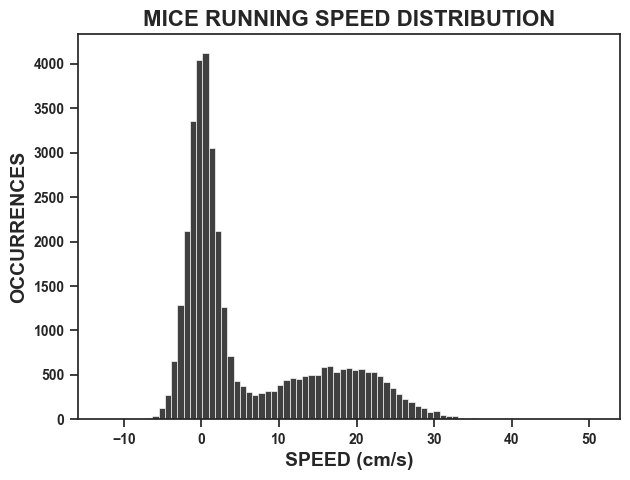

In [6]:
# CREATE HISTOGRAM TO VISUALIZE RUNNING SPEEDS (ARB. BINNED)
sns.set(style="ticks")
plt.figure(figsize=(7, 5))
speed_hist = sns.histplot(data=g_running_df["speed"], color="black")
speed_hist.set_xlabel("SPEED (cm/s)", fontdict={'fontsize': 14, 'fontweight': 'bold'}, labelpad=4)
speed_hist.set_ylabel("OCCURRENCES", fontdict={'fontsize': 14, 'fontweight': 'bold'}, labelpad=4)
speed_hist.set_title("MICE RUNNING SPEED DISTRIBUTION", fontdict={'fontsize': 16, 'fontweight': 'bold'})

plt.setp(speed_hist.get_xticklabels(), fontsize=10, fontweight="bold")
plt.setp(speed_hist.get_yticklabels(), fontsize=10, fontweight="bold")

plt.show()

In [7]:
### SEGMENTATION, AVERAGE SPEED, FIRING RATES BY ROI CALC ###
## Split on Arbitrary Values Based on Hist: Splitting by percentile/ occurance not logical given Dist
## Currently filtering 0-10 (Speed Values < 1.00 dropped later)

# Bin
bin_edges = [0, 10, 20, float('inf')]
bin_labels = ['Low (1-10)', 'Medium (10-20)', 'High (20+)']

# Holders
avg_speeds = []
g_visp_fr = []
g_visrl_fr = []
g_visam_fr = []

for index, row in g_stim_df.iterrows(): # Iter
    start = row['start_time']
    stop = row['stop_time']
    
    # Segment running data and calculate average speed
    seg = g_running_df[(g_running_df['timestamps'] >= start) & (g_running_df['timestamps'] <= stop)]
    avg_speed = seg['speed'].mean()
    avg_speeds.append(avg_speed)
    
    # Firing rates by ROI
    g_visp_segment_spikes = g_visp[(g_visp >= start) & (g_visp <= stop)] #VISP
    g_visp_fr.append(len(g_visp_segment_spikes) / (stop - start))
    
    g_visrl_segment_spikes = g_visrl[(g_visrl >= start) & (g_visrl <= stop)] #VISRL
    g_visrl_fr.append(len(g_visrl_segment_spikes) / (stop - start))
    
    g_visam_segment_spikes = g_visam[(g_visam >= start) & (g_visam <= stop)] #VISAM
    g_visam_fr.append(len(g_visam_segment_spikes) / (stop - start))

# Include computed in the DF
g_stim_df['average_speed'] = avg_speeds
g_stim_df['Group'] = pd.cut(avg_speeds, bins=bin_edges, labels=bin_labels, include_lowest=True) # Group
g_stim_df['VISp firing rate (Hz)'] = g_visp_fr
g_stim_df['VISrl firing rate (Hz)'] = g_visrl_fr
g_stim_df['VISam firing rate (Hz)'] = g_visam_fr

In [8]:
### DROP WHERE NO FIRING OCCURS, CUT WHERE MOVEMENT IS 0 ###
## No 0.0 for the VISrl and VISp values ~ Unless Data Changes, Can Leave Commented Out ##

g_stim_df2 = g_stim_df.copy() # Copy DF to maintain original

g_stim_df2['VISam firing rate (Hz)'] = g_stim_df2['VISam firing rate (Hz)'].replace(0, np.nan) # Replace 0 w NaN
g_stim_df2.dropna(subset=['VISam firing rate (Hz)'], inplace=True) # Drop NaN 
#g_stim_df2['VISrl firing rate (Hz)'] = g_stim_df2['VISrl firing rate (Hz)'].replace(0, np.nan)
#g_stim_df2.dropna(subset=['VISrl firing rate (Hz)'], inplace=True) # Drop NaN 
#g_stim_df2['VISp firing rate (Hz)'] = g_stim_df2['VISp firing rate (Hz)'].replace(0, np.nan)
#g_stim_df2.dropna(subset=['VISp firing rate (Hz)'], inplace=True) # Drop NaN 

# Cutting Where Movement is Nearly 0: For ACTIVE Movement, Miniscule Movements Irrelevant
g_stim_df = g_stim_df[g_stim_df['average_speed'] >= 1]
g_stim_df2 = g_stim_df2[g_stim_df2['average_speed'] >= 1]

group_names = ['Low (1-10)', 'Medium (10-20)', 'High (20+)']
groups = [g_stim_df[g_stim_df['Group'] == group_name] for group_name in group_names]

In [9]:
### ANOVA FOR EACH ROI ###

anova_results = {} # Performing ANOVA for each visual area
for area in ['VISp', 'VISrl']:
    area_data = [group[f'{area} firing rate (Hz)'] for group in groups]
    anova_result = f_oneway(*area_data)
    anova_results[area] = anova_result

for area, result in anova_results.items():
    print(f"ANOVA for {area}: F-statistic={result.statistic:.2f}, p-value={result.pvalue}")

group_names_2 = ['Low (1-10)', 'Medium (10-20)', 'High (20+)']
groups_2 = [g_stim_df2[g_stim_df2['Group'] == group_name_2] for group_name_2 in group_names_2]

area_data_2 = [group_2['VISam firing rate (Hz)'] for group_2 in groups_2]
anova_result_2 = f_oneway(*area_data_2)

print(f"ANOVA for VISam: F-statistic={anova_result_2.statistic:.2f}, p-value={anova_result_2.pvalue}")

ANOVA for VISp: F-statistic=1.68, p-value=0.1863262867400274
ANOVA for VISrl: F-statistic=21.03, p-value=1.0036808247151453e-09
ANOVA for VISam: F-statistic=0.30, p-value=0.7435745404284493


Linear Regression of VISp Firing Rate vs average_speed
R-squared: 8.090468484033689e-07
p-value: 0.9730899498559826
Standard error: 0.7587449784565786


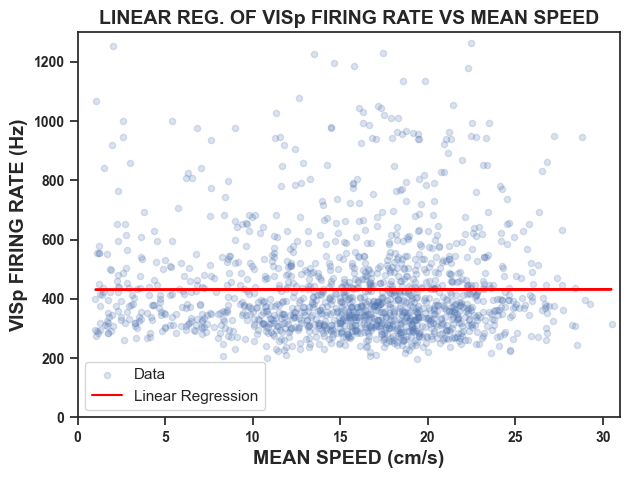

In [10]:
### FIGURE GENERATION: Linear Regression of VISp Firing Rate vs average_speed ###
visp_firing_rate = g_stim_df['VISp firing rate (Hz)']
visp_average_speed = g_stim_df['average_speed']

# Linear regression
plt.figure(figsize=(7, 5))
visp_slope, visp_intercept, visp_r_value, visp_p_value, visp_std_err = linregress(visp_average_speed, visp_firing_rate)
plt.scatter(g_stim_df['average_speed'], g_stim_df['VISp firing rate (Hz)'], label='Data', alpha = 0.2, s = 20)
visp_regression_line = visp_slope * g_stim_df['average_speed'] + visp_intercept
plt.plot(g_stim_df['average_speed'], visp_regression_line, color='red', label='Linear Regression')

# Plot Formatting
plt.title('LINEAR REG. OF VISp FIRING RATE VS MEAN SPEED', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('MEAN SPEED (cm/s)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('VISp FIRING RATE (Hz)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylim(0, 1300)
plt.xlim(0, 31)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend()

# Results
print('Linear Regression of VISp Firing Rate vs average_speed')
print("R-squared:", visp_r_value**2)
print("p-value:", visp_p_value)
print("Standard error:", visp_std_err)
plt.show()

Linear Regression of VISrl Firing Rate vs average_speed
R-squared: 0.021482690978537878
p-value: 3.262611143082586e-08
Standard error: 0.46777921778488407
Slope: -2.5998485916778957
Intercept: 461.2810078293489


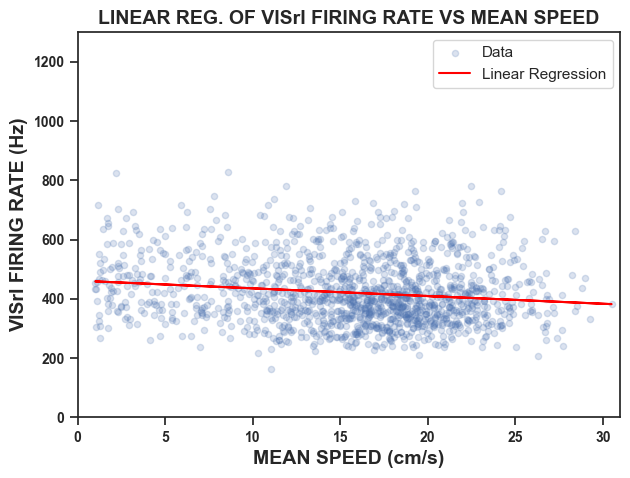

In [11]:
### FIGURE GENERATION: Linear Regression of VISrl Firing Rate vs average_speed ###
VISrl_firing_rate = g_stim_df['VISrl firing rate (Hz)']
VISrl_average_speed = g_stim_df['average_speed']

# Linear regression
plt.figure(figsize=(7, 5))
VISrl_slope, VISrl_intercept, VISrl_r_value, VISrl_p_value, VISrl_std_err = linregress(VISrl_average_speed, VISrl_firing_rate)
plt.scatter(g_stim_df['average_speed'], g_stim_df['VISrl firing rate (Hz)'], label='Data', alpha = 0.2, s = 20)
VISrl_regression_line = VISrl_slope * g_stim_df['average_speed'] + VISrl_intercept
plt.plot(g_stim_df['average_speed'], VISrl_regression_line, color='red', label='Linear Regression')

# Plot Formatting
plt.title('LINEAR REG. OF VISrl FIRING RATE VS MEAN SPEED', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('MEAN SPEED (cm/s)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('VISrl FIRING RATE (Hz)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylim(0, 1300)
plt.xlim(0, 31)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend()

#Results
print ("Linear Regression of VISrl Firing Rate vs average_speed")
print("R-squared:", VISrl_r_value**2)
print("p-value:", VISrl_p_value)
print("Standard error:", VISrl_std_err)
print("Slope:", VISrl_slope)
print("Intercept:", VISrl_intercept)
plt.show()

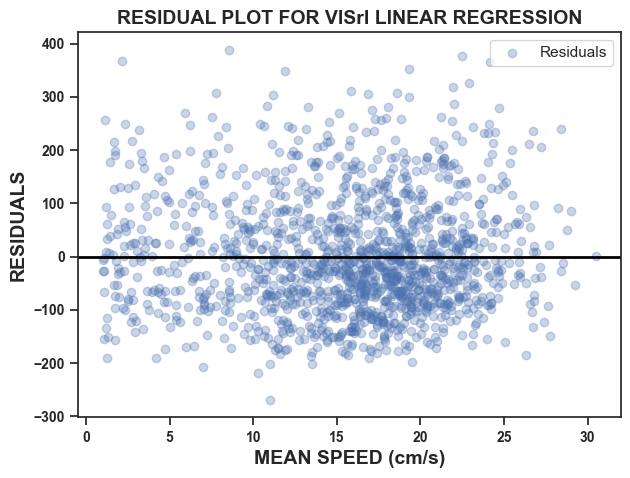

In [12]:
### FIGURE GENERATION: Residual Plot for VISrl Linear Regression ###
residuals = VISrl_firing_rate - VISrl_regression_line

# Plot residuals against average_speed
plt.figure(figsize=(7, 5))
plt.scatter(VISrl_average_speed, residuals, label='Residuals', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth = 2)  #LOBF (x = x0)

plt.title('RESIDUAL PLOT FOR VISrl LINEAR REGRESSION', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('MEAN SPEED (cm/s)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('RESIDUALS', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(False)
plt.legend()
plt.show()

Linear Regression of VISam Firing Rate vs average_speed
R-squared: 0.0005126793260452416
p-value: 0.46747472943583834
Standard error: 0.3707541946777273


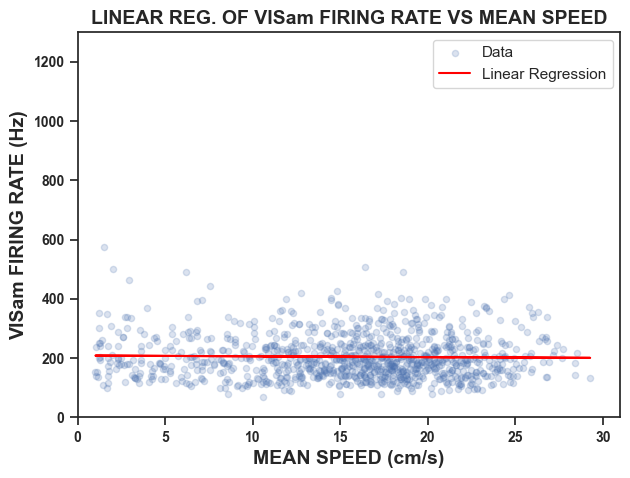

In [13]:
### FIGURE GENERATION: Linear Regression of VISam Firing Rate vs average_speed ###
VISam_firing_rate = g_stim_df2['VISam firing rate (Hz)']
VISam_average_speed = g_stim_df2['average_speed']

# Linear regression
plt.figure(figsize=(7, 5))
VISam_slope, VISam_intercept, VISam_r_value, VISam_p_value, VISam_std_err = linregress(VISam_average_speed, VISam_firing_rate)
plt.scatter(g_stim_df2['average_speed'], g_stim_df2['VISam firing rate (Hz)'], label='Data', alpha = 0.2, s = 20)
VISam_regression_line = VISam_slope * g_stim_df2['average_speed'] + VISam_intercept
plt.plot(g_stim_df2['average_speed'], VISam_regression_line, color='red', label='Linear Regression')

# Plot Formatting
plt.title('LINEAR REG. OF VISam FIRING RATE VS MEAN SPEED', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('MEAN SPEED (cm/s)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('VISam FIRING RATE (Hz)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylim(0, 1300)
plt.xlim(0, 31)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend()

# Results
print ("Linear Regression of VISam Firing Rate vs average_speed")
print("R-squared:", VISam_r_value**2)
print("p-value:", VISam_p_value)
print("Standard error:", VISam_std_err)
plt.show()

In [14]:
### TUREY HSD GENERATION ###
visrl_tukey_data = [group['VISrl firing rate (Hz)'] for group in groups]
flat = [value for sublist in visrl_tukey_data for value in sublist]
group_labels = [group_name for group_name, data in zip(group_names, visrl_tukey_data) for _ in data]
tukey_results = pairwise_tukeyhsd(flat, group_labels)
print(tukey_results)

tukey_results_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
p_values = tukey_results_df['p-adj'].astype(float)
p_values

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1       group2     meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
High (20+)     Low (1-10)  46.0568    0.0  25.3156   66.798   True
High (20+) Medium (10-20)  -2.6809 0.9196 -18.8126  13.4509  False
Low (1-10) Medium (10-20) -48.7377    0.0 -66.7648 -30.7105   True
------------------------------------------------------------------


0    0.0000
1    0.9196
2    0.0000
Name: p-adj, dtype: float64

Means:[460.0243446957901, 411.28666296951246, 413.9675313300301]
n=[254, 811, 344]
SEM:[6.971946963373879, 3.7222283021549925, 5.697465653380579]


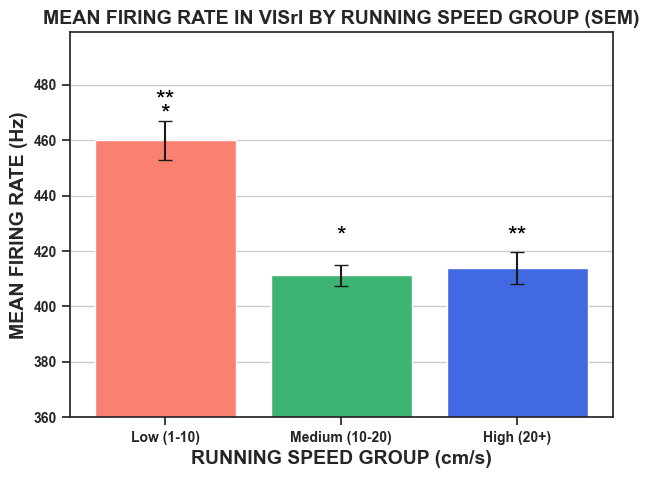

In [15]:
### FIGURE GENERATION: Barplot of Mean Firing Rate in VISrl by Running Speed Group with SEM ###
visrl_data = [group['VISrl firing rate (Hz)'].mean() for group in groups]
visrl_sem = [group['VISrl firing rate (Hz)'].sem() for group in groups]
n = [len(group['VISrl firing rate (Hz)']) for group in groups]

print (f"Means:{visrl_data}")
print (f"n={n}")
print (f"SEM:{visrl_sem}")

sig = '*'
sig2 = '**'

colors = ['salmon', 'mediumseagreen', 'royalblue']

plt.figure(figsize=(7, 5))
bars = plt.bar(group_names, visrl_data, yerr=visrl_sem, capsize=5, color=colors)
plt.title('MEAN FIRING RATE IN VISrl BY RUNNING SPEED GROUP (SEM)', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('RUNNING SPEED GROUP (cm/s)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('MEAN FIRING RATE (Hz)', labelpad = 4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y')
plt.ylim(360, 499)

asterisk_pos = [(0, 465), (1, 421)]
for index, y_coord in asterisk_pos:
    plt.text(index, y_coord, sig, ha='center', va='bottom', color='black', fontsize=18)
    
dub_asterisk_pos = [(0, 470), (2, 421)]
for index, y_coord in dub_asterisk_pos:
    plt.text(index, y_coord, sig2, ha='center', va='bottom', color='black', fontsize=18)

plt.show()

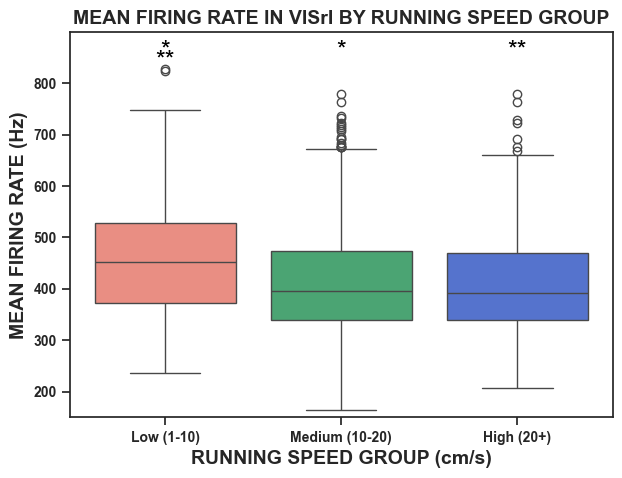

In [16]:
### FIGURE GENERATION: Boxplot of Mean Firing Rate in VISrl by Running Speed Group with SEM ###
# This is different
visrl_data = [group['VISrl firing rate (Hz)'].values for group in groups]

plt.figure(figsize=(7, 5))
sns.boxplot(data=visrl_data, palette=colors)

for i, group_data in enumerate(visrl_data):
    mean_val = group_data.mean()
    plt.scatter(i, mean_val, color='black', marker='o', s=100, label='Mean' if i == 0 else "")

plt.title('MEAN FIRING RATE IN VISrl BY RUNNING SPEED GROUP', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('RUNNING SPEED GROUP (cm/s)', labelpad=4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('MEAN FIRING RATE (Hz)', labelpad=4, fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks([0, 1, 2], group_names, fontsize=10, fontweight='bold')  # Adjust if you have more or fewer groups
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(axis='y')
plt.ylim(150, 899)

asterisk_pos = [(0, 840), (1, 840)]
for index, y_coord in asterisk_pos:
    plt.text(index, y_coord, sig, ha='center', va='bottom', color='black', fontsize=18)
    
dub_asterisk_pos = [(0, 820), (2, 840)]
for index, y_coord in dub_asterisk_pos:
    plt.text(index, y_coord, sig2, ha='center', va='bottom', color='black', fontsize=18)
    
plt.grid(False)
plt.show()

In [17]:
### Please let me know if any housekeeping is necessary. Thank you! 
print("Done!")

Done!
